In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
from tqdm import tqdm
import numpy as np

In [2]:
# Définition du modèle CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement des datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Prendre un sous-ensemble des données d'entraînement (par exemple 1% des données)
train_subset_size = int(0.05 * len(trainset))  # 1% des données
train_indices = np.random.choice(len(trainset), train_subset_size, replace=False)  # Échantillonnage aléatoire
trainset_ = torch.utils.data.Subset(trainset, train_indices)  # Créer un sous-ensemble

# Prendre un sous-ensemble des données de test (par exemple 1% des données)
test_subset_size = int(0.05 * len(testset))  # 1% des données
test_indices = np.random.choice(len(testset), test_subset_size, replace=False)  # Échantillonnage aléatoire
testset = torch.utils.data.Subset(testset, test_indices)  # Créer un sous-ensemble

In [5]:
# Création des labels aléatoires
random_labels = [random.randint(0, 9) for _ in range(len(trainset_))]
trainset_random = [(img, random_labels[i]) for i, (img, _) in enumerate(trainset_)]

In [6]:
len(trainset)

50000

In [7]:
len(trainset_random)

2500

In [8]:
# Création des DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
trainloader_random = torch.utils.data.DataLoader(trainset_random, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)


In [9]:
def train(model, trainloader, criterion, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

In [10]:
def test(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * (1 - correct / total)


In [11]:
# Entraînement et test du modèle avec les bons labels
model_clean = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_clean.parameters(), lr=0.001)
print("Training on correct labels:")
train(model_clean, trainloader, criterion, optimizer)
error_clean = test(model_clean, testloader)
print(f"Test Error (correct labels): {error_clean:.2f}%")


Training on correct labels:


Epoch 1: 100%|██████████| 1563/1563 [01:43<00:00, 15.09it/s]


Epoch 1, Loss: 1.2983


Epoch 2: 100%|██████████| 1563/1563 [01:47<00:00, 14.51it/s]


Epoch 2, Loss: 0.9138


Epoch 3: 100%|██████████| 1563/1563 [01:44<00:00, 14.95it/s]


Epoch 3, Loss: 0.7459


Epoch 4: 100%|██████████| 1563/1563 [01:44<00:00, 14.99it/s]


Epoch 4, Loss: 0.6183


Epoch 5: 100%|██████████| 1563/1563 [01:55<00:00, 13.56it/s]


Epoch 5, Loss: 0.5115


Testing: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s]

Test Error (correct labels): 28.60%


In [12]:
# Entraînement et test du modèle avec les labels aléatoires
model_random = SimpleCNN()
optimizer = optim.Adam(model_random.parameters(), lr=0.001)
print("Training on random labels:")
train(model_random, trainloader_random, criterion, optimizer,25)
error_random = test(model_random, testloader)
print(f"Test Error (random labels): {error_random:.2f}%")

Training on random labels:


Epoch 1: 100%|██████████| 40/40 [00:03<00:00, 11.59it/s]


Epoch 1, Loss: 2.3054


Epoch 2: 100%|██████████| 40/40 [00:04<00:00,  8.91it/s]


Epoch 2, Loss: 2.3014


Epoch 3: 100%|██████████| 40/40 [00:03<00:00, 11.83it/s]


Epoch 3, Loss: 2.2998


Epoch 4: 100%|██████████| 40/40 [00:03<00:00, 11.62it/s]


Epoch 4, Loss: 2.2874


Epoch 5: 100%|██████████| 40/40 [00:03<00:00, 11.26it/s]


Epoch 5, Loss: 2.2563


Epoch 6: 100%|██████████| 40/40 [00:04<00:00,  9.28it/s]


Epoch 6, Loss: 2.1938


Epoch 7: 100%|██████████| 40/40 [00:03<00:00, 11.73it/s]


Epoch 7, Loss: 2.0934


Epoch 8: 100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


Epoch 8, Loss: 1.9701


Epoch 9: 100%|██████████| 40/40 [00:04<00:00,  9.00it/s]


Epoch 9, Loss: 1.8008


Epoch 10: 100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


Epoch 10, Loss: 1.5837


Epoch 11: 100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 11, Loss: 1.3775


Epoch 12: 100%|██████████| 40/40 [00:03<00:00, 11.19it/s]


Epoch 12, Loss: 1.0928


Epoch 13: 100%|██████████| 40/40 [00:04<00:00,  9.15it/s]


Epoch 13, Loss: 0.8107


Epoch 14: 100%|██████████| 40/40 [00:03<00:00, 11.60it/s]


Epoch 14, Loss: 0.5549


Epoch 15: 100%|██████████| 40/40 [00:03<00:00, 11.55it/s]


Epoch 15, Loss: 0.3724


Epoch 16: 100%|██████████| 40/40 [00:04<00:00,  8.86it/s]


Epoch 16, Loss: 0.2411


Epoch 17: 100%|██████████| 40/40 [00:03<00:00, 10.99it/s]


Epoch 17, Loss: 0.1353


Epoch 18: 100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch 18, Loss: 0.0844


Epoch 19: 100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


Epoch 19, Loss: 0.0511


Epoch 20: 100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


Epoch 20, Loss: 0.0634


Epoch 21: 100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


Epoch 21, Loss: 0.0296


Epoch 22: 100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


Epoch 22, Loss: 0.0149


Epoch 23: 100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


Epoch 23, Loss: 0.0156


Epoch 24: 100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


Epoch 24, Loss: 0.0097


Epoch 25: 100%|██████████| 40/40 [00:03<00:00, 10.91it/s]


Epoch 25, Loss: 0.0106


Testing: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

Test Error (random labels): 93.00%


In [13]:
def compute_layer_cushion_F(A, x):
    """
    Calcul du layer cushion pour une couche donnée du réseau.

    Arguments:
    A -- la matrice de poids (ou tenseur) de la couche (forme : [out_channels, in_channels, kernel_size, kernel_size])
    x -- l'entrée de la couche précédente (forme : [batch_size, in_channels, height, width])

    Retour:
    layer_cushion -- la valeur du layer cushion (μi)
    """

    # 1. Appliquer ReLU sur l'entrée x (couche précédente)
    x_relu = torch.relu(x)

    # 2. Calculer la norme Frobenius de A
    norm_A = torch.norm(A, p='fro')  # Norme Frobenius de A

    # 3. Calculer la norme de l'entrée x après activation (sur tout le batch)
    norm_x = torch.norm(x_relu, p=2)  # Norme L2 de x_relu

    # 4. Effectuer la convolution pour obtenir la sortie de la couche
    with torch.no_grad():  # Désactiver les gradients pour cette étape
        output = torch.nn.functional.conv2d(x_relu, A)  # Appliquer la convolution

    # 5. Calculer la norme de la sortie
    norm_output = torch.norm(output, p=2)  # Norme L2 de la sortie de la couche

    # 6. Calculer le layer cushion (μi)
    layer_cushion = norm_output / (norm_A * norm_x)

    return layer_cushion

In [14]:
def compute_activation_contraction(x):
  norm_phi = torch.norm(torch.relu(x),p=2)
  norm_x = torch.norm(x,p=2)
  return norm_phi/norm_x


In [15]:
def calculate_layer_cushion_for_dataset(model, trainloader, weigthss,couche):
    """
    Calculer le layer cushion pour plusieurs données dans le trainset.

    Arguments:
    model -- le modèle préentraîné (par exemple, VGG-19)
    trainloader -- DataLoader contenant les données d'entraînement
    device -- le périphérique ('cpu' ou 'cuda') pour les calculs

    Retour:
    layer_cushions -- liste des valeurs des layer cushions pour chaque couche
    """
    model.eval()  # Mode évaluation (désactive le dropout, batchnorm, etc.)

    # Liste pour stocker les résultats des layer cushions
    layer_cushions = []
    activation_contractions = []
    layer_cushions_1i = []
    interlayer_smoothness = []
    conv_layers = list(weigthss.keys())
    # Parcourir le DataLoader
    for inputs, _ in trainloader:
        print("!!")

        # Propager les données à travers chaque couche du modèle
        x = inputs
        i = 0
        for name, module in tqdm(model.named_modules()):  # Récupérer chaque module du modèle
          if isinstance(module, torch.nn.Conv2d):  # Vérifier si c'est une couche Conv2d
              # Passer les entrées à travers la couche actuelle
              print(name)
              x_ = module(x)

              # Calculer le layer cushion pour cette couche
              weight = module.weight  # Matrice de poids de la couche actuelle
              if i != 0 and name == couche:
                  layer_cushion = compute_layer_cushion_F(weight, x)
                  layer_cushions.append(layer_cushion)
                  activation_contraction = compute_activation_contraction(x)
                  activation_contractions.append(activation_contraction)

                  # Calculer le layer cushion entre deux couches
                  #layer_cushion_1i = calculate_minimal_interlayer_cushion(weight)
                  #layer_cushions_1i.append(layer_cushion_1i)

                  # Si ce n'est pas la dernière couche, obtenir la matrice de poids de la couche suivante
                  #if i + 1 < len(list(model.modules())):  # S'assurer qu'il y a un module suivant
                   #  next_module_w = weigthss[conv_layers[i]]

                    # A_ = next_module_w  # Récupérer la matrice de poids du module suivant
                     #interlayer = compute_interlayer_smoothness(A_, x_, np.prod(A_.size()))
                     #interlayer_smoothness.append(interlayer)

              # Mettre à jour x avec la sortie du module actuel
              x = x_
              i += 1
    return layer_cushions,activation_contractions,layer_cushions_1i,interlayer_smoothness

In [16]:
def get_all_weights_conv(model):
    weights = {}

    # Extraire les poids des couches convolutionnelles
    for name, layer in model.named_children():
        if isinstance(layer, nn.Conv2d):
            weights[name] = layer.weight.data.clone()

    return weights


In [17]:
weights_alea = get_all_weights_conv(model_random)
weights_train = get_all_weights_conv(model_clean)

In [18]:
weights_alea.keys()

dict_keys(['conv1', 'conv2'])

In [19]:
layer_cushions_alea, activation_c_alea, mini_cushion_alea,smoothness_alea = calculate_layer_cushion_for_dataset(model_random, testloader, weights_alea,"conv2")
layer_cushions_train, activation_c_train, mini_cushion_train,smoothness_train = calculate_layer_cushion_for_dataset(model_clean, testloader, weights_train,"conv2")

!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 33.78it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 23.79it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 22.52it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 17.86it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 21.99it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 19.72it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 20.23it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 22.22it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 20.57it/s]


!!


0it [00:00, ?it/s]

conv1
conv2


7it [00:00, 21.15it/s]


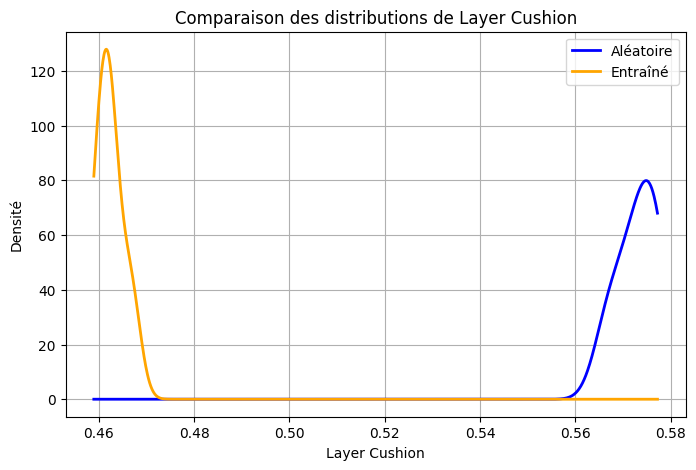

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import gaussian_kde

def plot_density_comparison(data1, data2, label1="Aléatoire", label2="Entraîné", color1="blue", color2="orange"):
    """
    Trace la densité des distributions de deux ensembles de données.

    Arguments :
    - data1, data2 : listes de tenseurs PyTorch (ex: [tensor(0.12), tensor(0.13), ...])
    - label1, label2 : noms des séries de données
    - color1, color2 : couleurs des courbes
    """
    # Convertir les tensors en scalaires
    data1 = [x.item() for x in data1]
    data2 = [x.item() for x in data2]

    plt.figure(figsize=(8, 5))

    # Estimation de la densité (KDE)
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)

    # Définir la plage de x
    x_min = min(min(data1), min(data2))
    x_max = max(max(data1), max(data2))
    x_range = np.linspace(x_min, x_max, 1000)

    # Tracer les courbes de densité
    plt.plot(x_range, kde1(x_range), color=color1, label=label1, linewidth=2)
    plt.plot(x_range, kde2(x_range), color=color2, label=label2, linewidth=2)

    # Ajout de labels et légende
    plt.xlabel("Layer Cushion")
    plt.ylabel("Densité")
    plt.title("Comparaison des distributions de Layer Cushion")
    plt.legend()
    plt.grid(True)

    # Affichage
    plt.show()

# Appliquer sur tes listes
plot_density_comparison(layer_cushions_alea, layer_cushions_train)
